###Stock Price Prediction Using ARIMA and XGBoost

In [ ]:
!pip install pmdarima optuna ta

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from ta.momentum import StochasticOscillator
import xgboost as xgb
import optuna
import itertools
import warnings
warnings.filterwarnings("ignore")

##Data Collection and Cleaning

In [ ]:
stocks = ['AAPL', 'GOOGL', 'MS', 'JPM', 'GS']

In [ ]:
def get_stock_data(ticker, start_date='2014-01-01', end_date='2024-01-01'):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Returns'] = data['Close'].pct_change()
    data['Volatility'] = data['Returns'].rolling(window=20).std() * np.sqrt(252)
    return data.dropna()

In [ ]:
stock_data = {stock: get_stock_data(stock) for stock in stocks}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(f"\n Apple's Stock Summary Statistics:")
print(stock_data['AAPL'].describe())


 Apple's Stock Summary Statistics:
              Open         High          Low        Close    Adj Close  \
count  2467.000000  2467.000000  2467.000000  2467.000000  2467.000000   
mean     79.025609    79.886999    78.216251    79.090867    76.959568   
std      56.105067    56.741065    55.516282    56.159839    56.518355   
min      18.501785    18.610357    18.261786    18.498571    16.271753   
25%      30.816250    31.183749    30.596250    30.832500    27.873363   
50%      49.497501    49.962502    48.982498    49.480000    47.753014   
75%     135.744995   137.309998   133.770004   135.379997   133.875381   
max     198.020004   199.619995   197.000000   198.110001   197.589523   

             Volume      Returns   Volatility        EMA_9        SMA_5  \
count  2.467000e+03  2467.000000  2467.000000  2467.000000  2467.000000   
mean   1.326253e+08     0.001101     0.257385    78.807346    78.949833   
std    7.722875e+07     0.017922     0.122914    55.964833    56.071080 

In [ ]:
def check_missing_values(data):
    missing = data.isnull().sum()
    print("Missing values:")
    print(missing[missing > 0])

In [ ]:
for stock, data in stock_data.items():
    print(f"\nChecking missing values for {stock}")
    check_missing_values(data)



Checking missing values for AAPL
Missing values:
Series([], dtype: int64)

Checking missing values for GOOGL
Missing values:
Series([], dtype: int64)

Checking missing values for MS
Missing values:
Series([], dtype: int64)

Checking missing values for JPM
Missing values:
Series([], dtype: int64)

Checking missing values for GS
Missing values:
Series([], dtype: int64)


In [ ]:
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

In [ ]:
for stock, data in stock_data.items():
    print(f"\nADF Test for {stock} closing prices:")
    adf_test(data['Close'])

print("\nData preparation completed.")


ADF Test for AAPL closing prices:
ADF Statistic: 0.2600102848165922
p-value: 0.9754335297730095
Critical Values:
	1%: -3.4329927491693426
	5%: -2.8627075477802673
	10%: -2.567391531704927

ADF Test for GOOGL closing prices:
ADF Statistic: 0.1528833728713982
p-value: 0.969491647478925
Critical Values:
	1%: -3.432997028182592
	5%: -2.862709437378743
	10%: -2.5673925377546976

ADF Test for MS closing prices:
ADF Statistic: -0.8181850817301802
p-value: 0.813721890223286
Critical Values:
	1%: -3.432990614846413
	5%: -2.8627066052691217
	10%: -2.567391029898424

ADF Test for JPM closing prices:
ADF Statistic: -0.8664246544132029
p-value: 0.7988281334719893
Critical Values:
	1%: -3.4329938176251593
	5%: -2.8627080196071697
	10%: -2.567391782912405

ADF Test for GS closing prices:
ADF Statistic: -1.1431706056813107
p-value: 0.6975526797714083
Critical Values:
	1%: -3.4329842325121738
	5%: -2.862703786843828
	10%: -2.567389529328891

Data preparation completed.


##Exploratory Data Analysis

Closing Price vs Date Graph

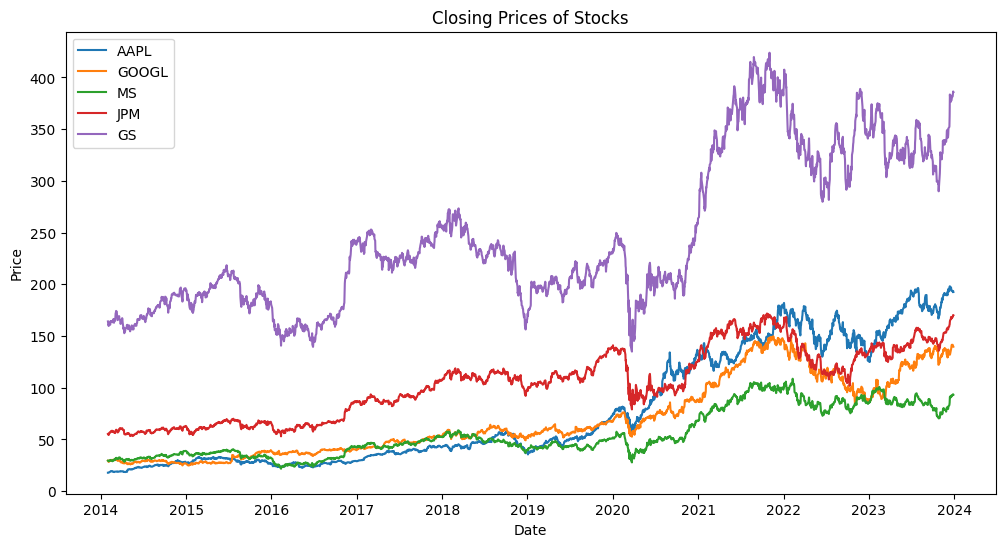

In [ ]:
plt.figure(figsize=(12, 6))
for stock, data in stock_data.items():
    plt.plot(data.index, data['Close'], label=stock)
plt.title('Closing Prices of Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Seasonal Decomposition Graph of Different Stocks

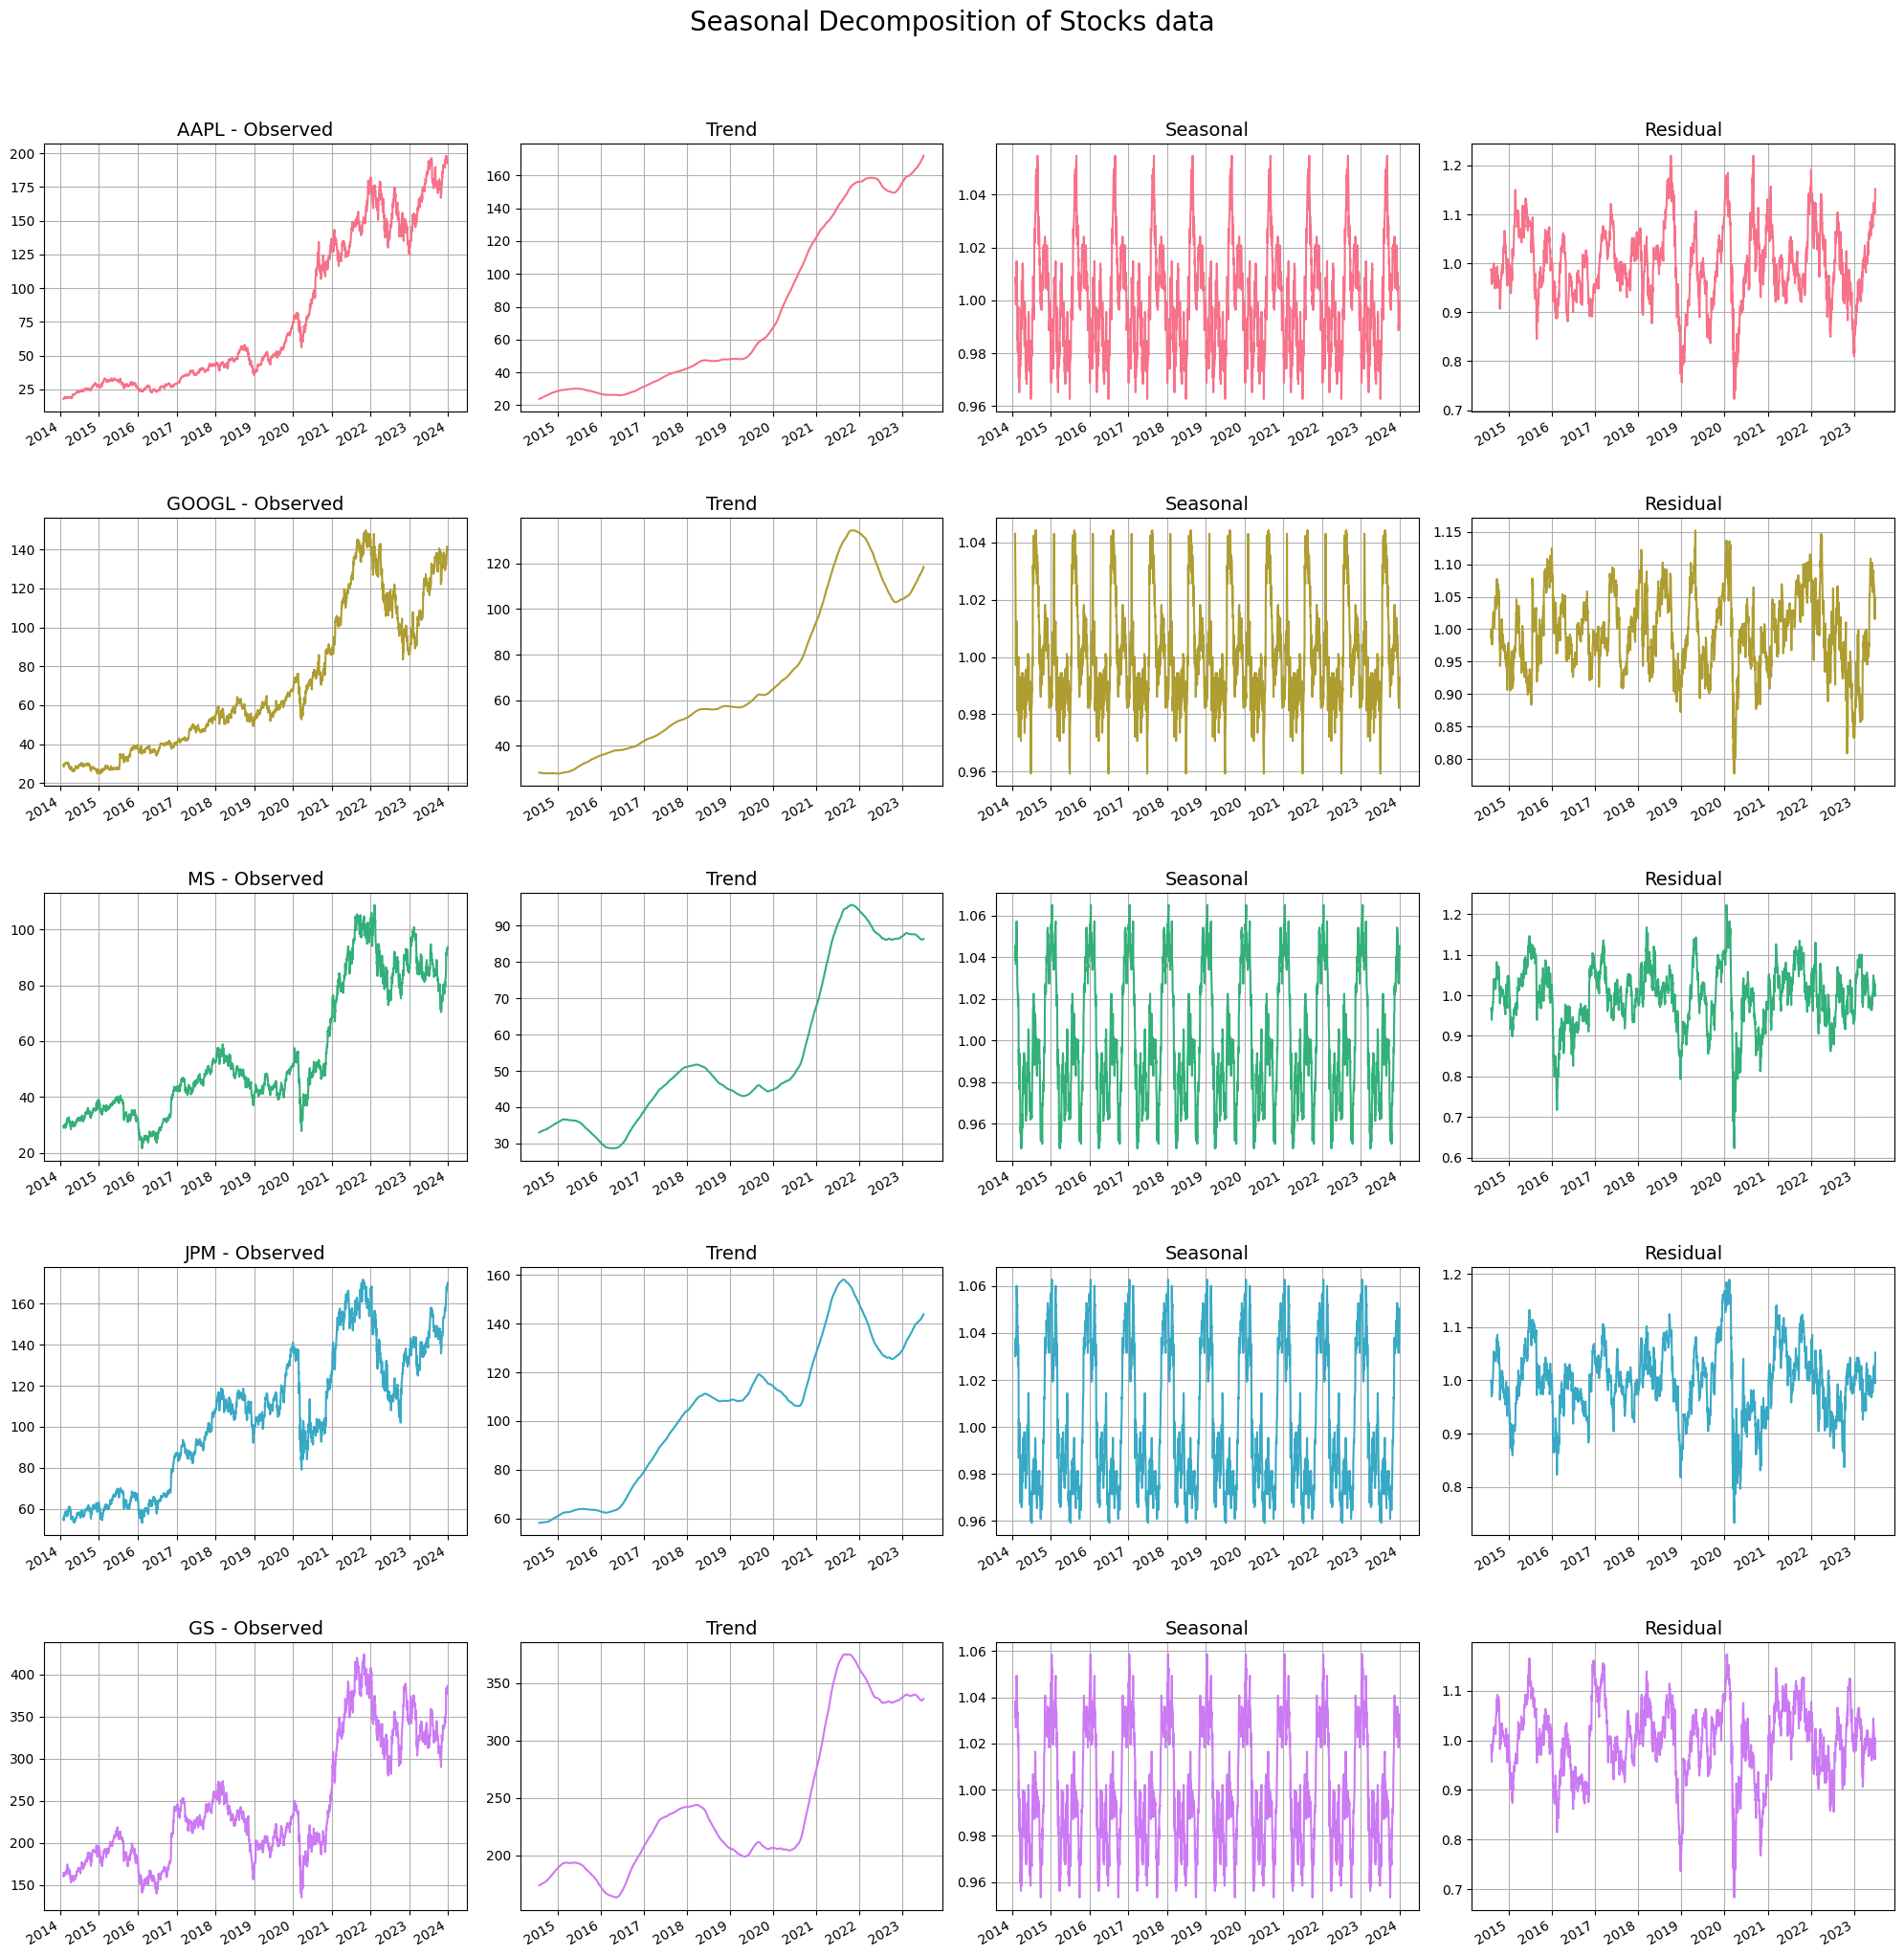

In [ ]:
num_stocks = len(stock_data)
fig, axes = plt.subplots(num_stocks, 4, figsize=(20, 4*num_stocks))
fig.suptitle('Seasonal Decomposition of Stocks data', fontsize=20, y=1.02)

if num_stocks == 1:
    axes = [axes]

sns.set_palette("husl", num_stocks)

for (stock, data), ax, color in zip(stock_data.items(), axes, sns.color_palette()):
    result = seasonal_decompose(data['Close'], model='multiplicative', period=252)

    result.observed.plot(ax=ax[0], color=color)
    ax[0].set_title(f'{stock} - Observed', fontsize=14)
    ax[0].grid(True)

    result.trend.plot(ax=ax[1], color=color)
    ax[1].set_title('Trend', fontsize=14)
    ax[1].grid(True)

    result.seasonal.plot(ax=ax[2], color=color)
    ax[2].set_title('Seasonal', fontsize=14)
    ax[2].grid(True)

    result.resid.plot(ax=ax[3], color=color)
    ax[3].set_title('Residual', fontsize=14)
    ax[3].grid(True)

    for a in ax:
        a.set_xlabel('')
        a.set_ylabel('')
        a.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(top=0.95, hspace=0.4)
plt.show()

Volatility Graph

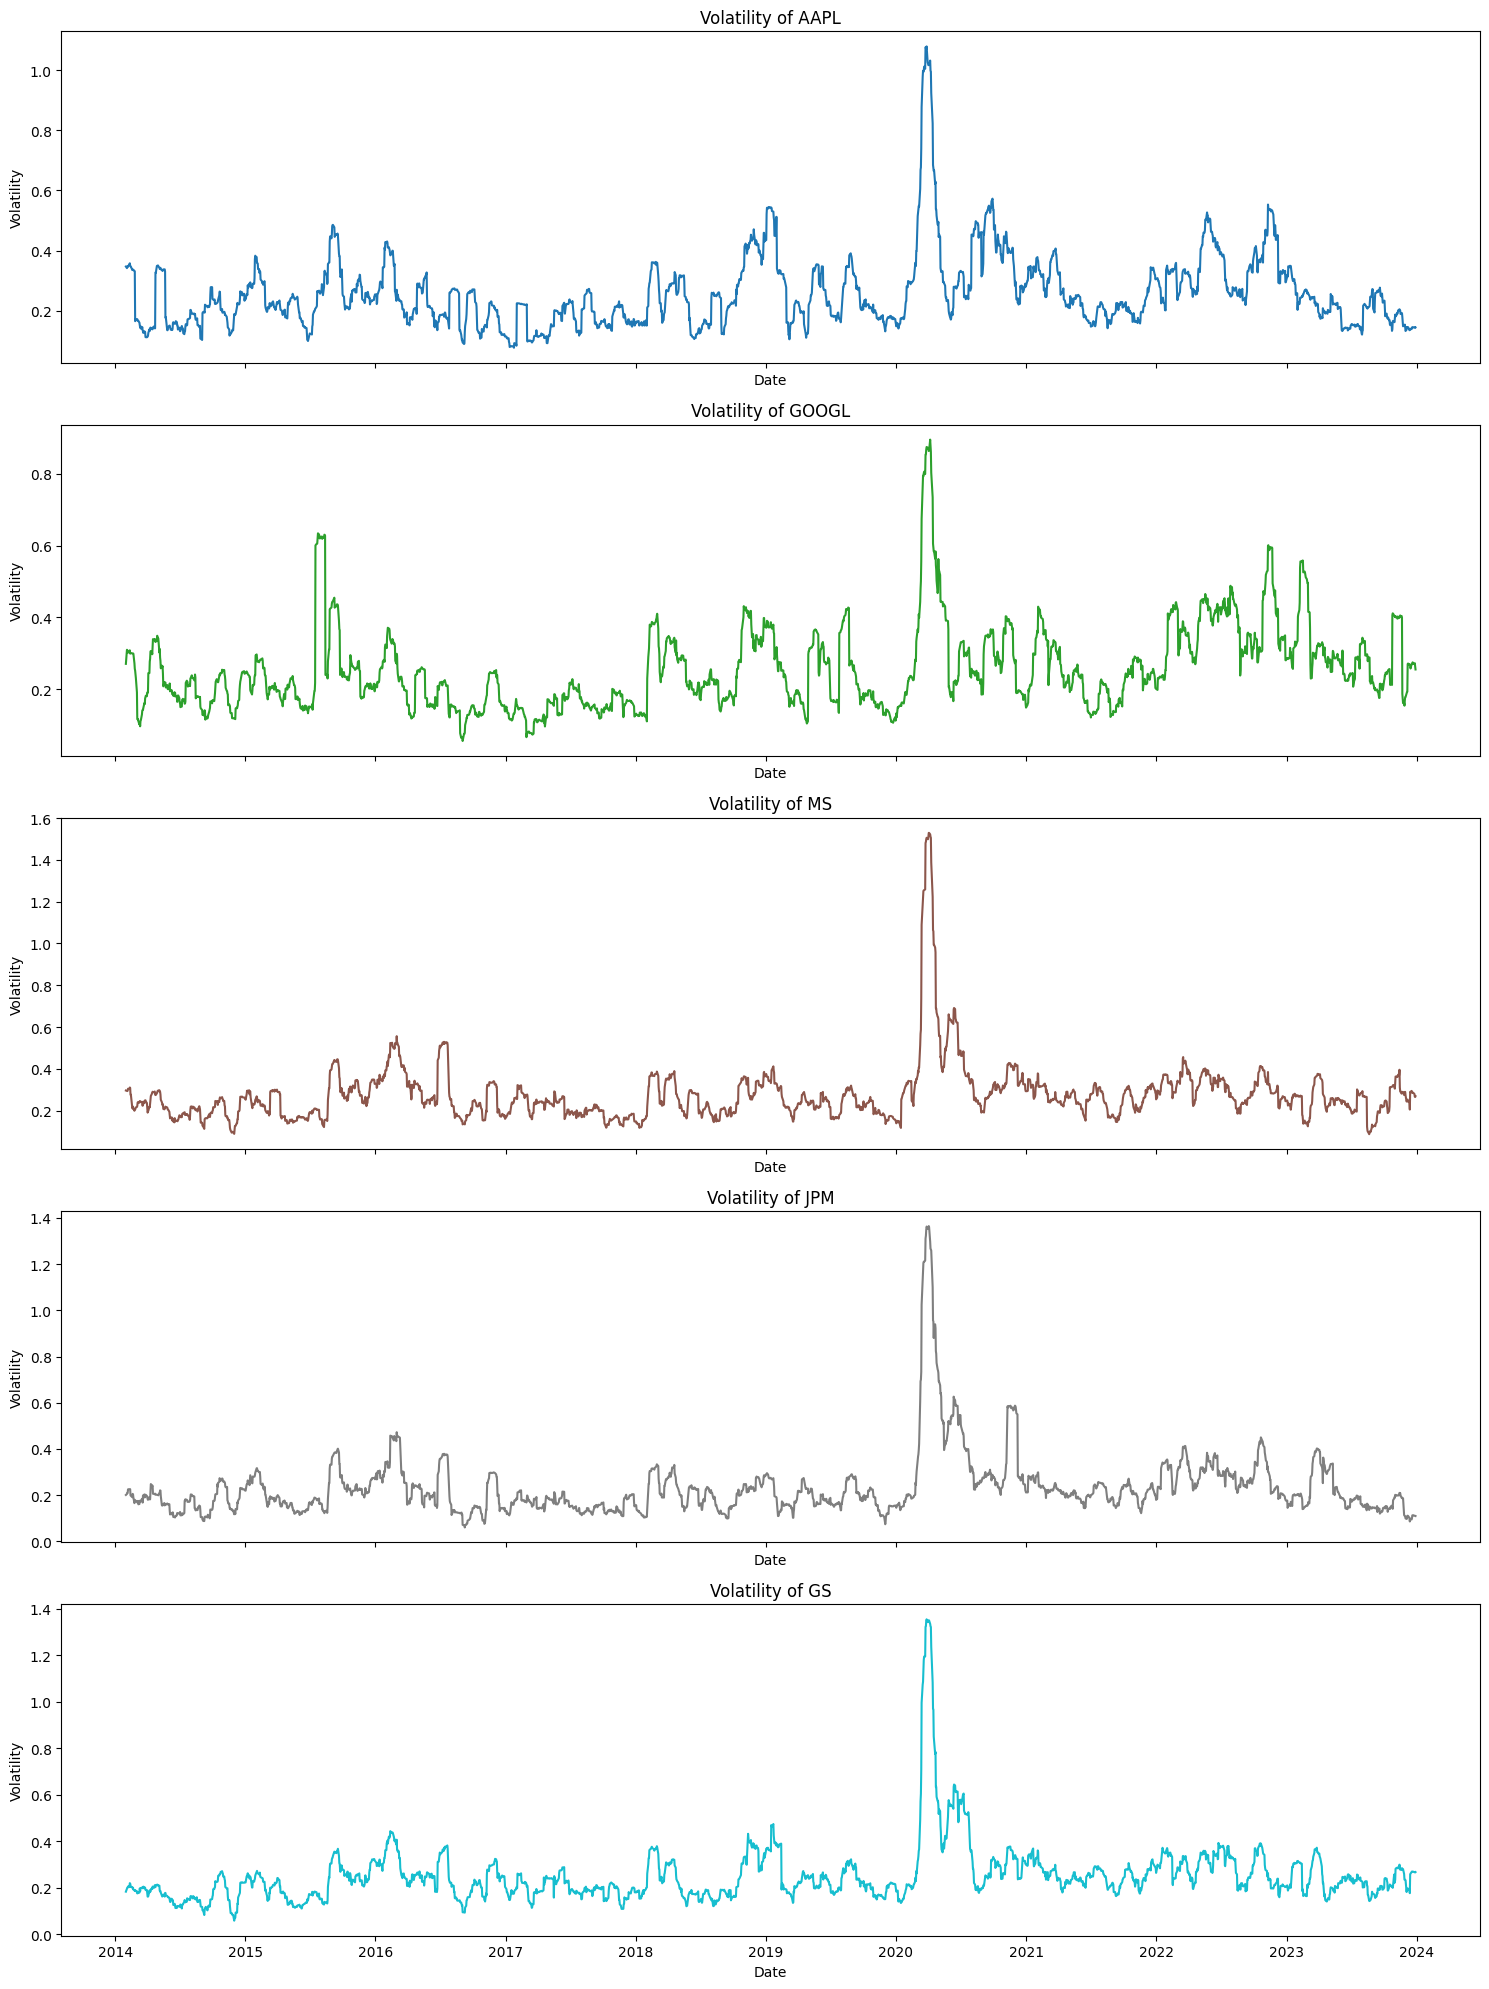

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20), sharex=True)

axes = axes.flatten()
colors = plt.cm.get_cmap('tab10', len(stock_data))

for i, (ticker, data) in enumerate(stock_data.items()):
    axes[i].plot(data.index, data['Volatility'], color=colors(i))
    axes[i].set_title(f'Volatility of {ticker}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()

Volume vs Date Graph

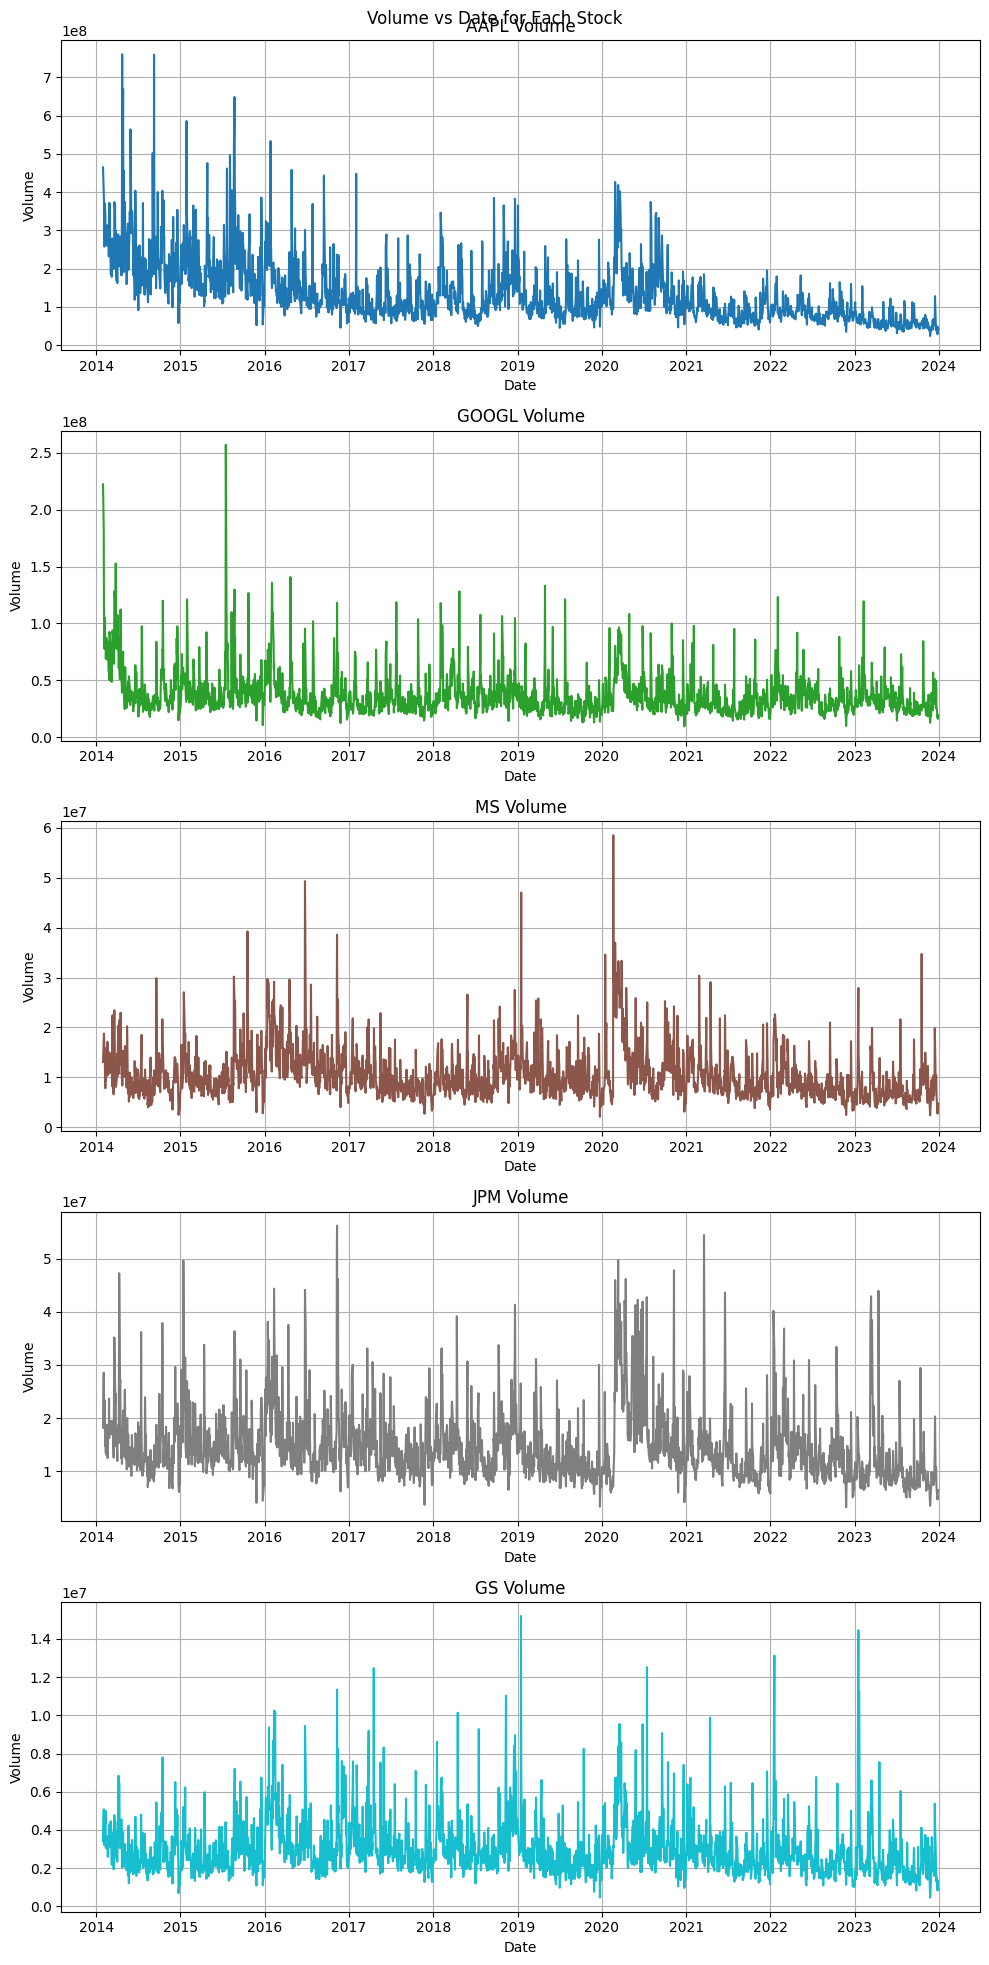

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
fig.suptitle('Volume vs Date for Each Stock')

colors = plt.cm.get_cmap('tab10', len(stock_data))

for i, (stock, df) in enumerate(stock_data.items()):
    axs[i].plot(df.index, df['Volume'], color=colors(i))
    axs[i].set_title(f'{stock} Volume')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Volume')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

##ARIMA MODEL For Morgan Stanley Stock

In [ ]:
MS_data = stock_data['MS']['Close']
train_size = int(len(MS_data) * 0.8)
train, test = MS_data[:train_size], MS_data[train_size:]

Test Data vs Train Data Graph

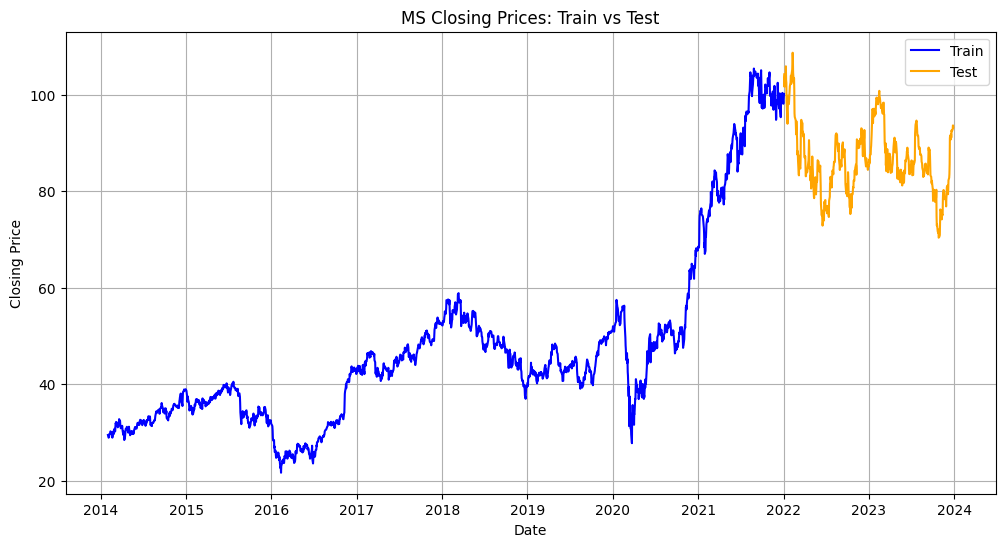

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.title('MS Closing Prices: Train vs Test')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train.index = pd.DatetimeIndex(train.index).to_period('D')
test.index = pd.DatetimeIndex(test.index).to_period('D')

In [ ]:
def evaluate_forecast(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [ ]:
model = auto_arima(train, seasonal=False, trace=True,max_p=3,max_q=3)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5298.559, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5300.881, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5299.351, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5299.632, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5301.885, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5297.974, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5297.632, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5294.344, Time=0.62 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5294.000, Time=2.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5272.445, Time=9.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5272.005, Time=9.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5271.683, Time=5.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5294.429, Time=1.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5301.005, Time=2.53 sec
 ARIMA(3,1,2)(0,0,0)[0]          

In [ ]:
def arima_forecast(history, order):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

In [ ]:
history = [x for x in train]
predictions = []
order = model.order

for t in range(len(test)):
    yhat = arima_forecast(history, order)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
arima_predictions = pd.Series(predictions, index=test.index)

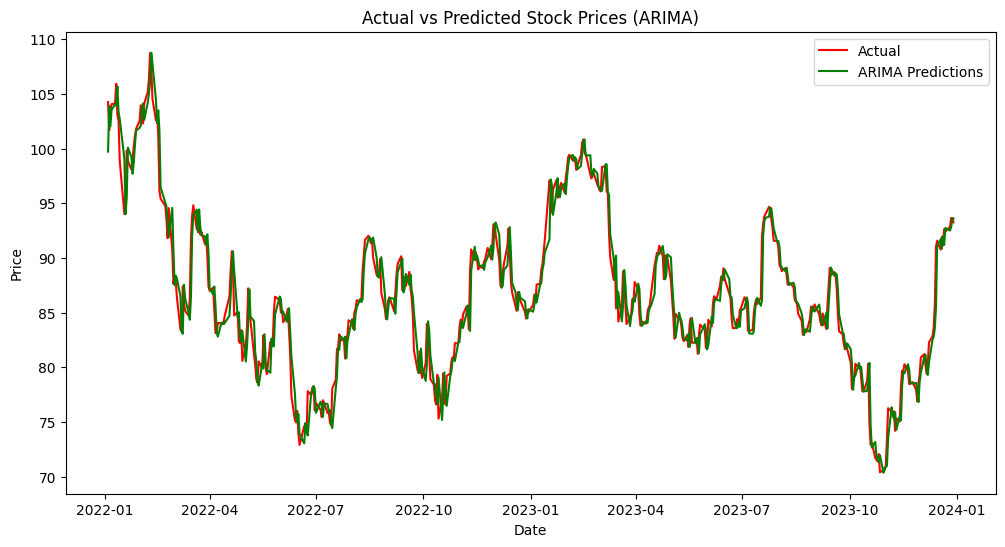

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test.index.to_timestamp(), test.values, 'red', label='Actual')
plt.plot(test.index.to_timestamp(), arima_predictions, 'green', label='ARIMA Predictions')
plt.title('Actual vs Predicted Stock Prices (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Feature Engineering

In [ ]:
def engineer_features(data):
    df = data.copy()

    # EMA_9
    df['EMA_9'] = df['Close'].ewm(span=9, adjust=False).mean()

    # Simple Moving Averages
    for window in [5, 10, 15, 30]:
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    # RSI (14-day period is standard)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # MACD Signal Line (9-day EMA of MACD)
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Stochastic']=StochasticOscillator(df['High'],df['Low'],df['Close']).stoch()

    # Drop rows with NaN values and unnecessary columns
    df = df.drop(['EMA_12', 'EMA_26'], axis=1).dropna()

    return df

In [ ]:
for stock in stocks:
    stock_data[stock] = engineer_features(stock_data[stock])

print(stock_data['JPM'].head())

                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2014-03-14  57.110001  57.529999  56.619999  56.799999  42.495697  18635800   
2014-03-17  57.209999  57.700001  57.049999  57.580002  43.079285  13581400   
2014-03-18  57.820000  58.160000  57.619999  58.060001  43.438381  12554800   
2014-03-19  57.990002  58.930000  57.889999  58.299999  43.617943  21450700   
2014-03-20  58.360001  60.490002  58.130001  60.110001  44.972122  33736500   

             Returns  Volatility      EMA_9      SMA_5  SMA_10     SMA_15  \
Date                                                                        
2014-03-14 -0.010798    0.175889  57.751545  57.905999  57.946  57.651999   
2014-03-17  0.013732    0.183315  57.717236  57.581999  58.083  57.622000   
2014-03-18  0.008336    0.184653  57.785789  57.556000  58.163  57.690666   
2014-03-19  0.004134    0.168052  57.888631  57.632000  58.17

Gradient Boosting

In [ ]:
X = stock_data['MS'].drop(['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume', 'Volatility', 'Returns'], axis=1)
y = stock_data['MS']['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
X.head()

,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal,Stochastic
Date,,,,,,,,,
2014-03-14,31.357051,31.562001,31.519,31.087333,30.318333,57.117131,0.516257,0.489664,51.063854
2014-03-17,31.359641,31.410001,31.630,31.158000,30.380334,65.900414,0.488840,0.489499,59.270558
2014-03-18,31.417713,31.400000,31.685,31.287334,30.470333,66.223922,0.484124,0.488424,65.131585
2014-03-19,31.496170,31.474000,31.669,31.412000,30.563333,64.471068,0.487676,0.488275,67.625899
2014-03-20,31.754936,31.744000,31.764,31.574000,30.683667,67.927958,0.563078,0.503235,90.220892


##XGBoost

In [ ]:
# Define the objective function
def objective(trial):
    # Suggest hyperparameters for XGBoost
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.8, 1.0),
        'objective': 'reg:squarederror',  # Objective function for regression
        'random_state': 42
    }

    # Initialize XGBoost Regressor with suggested parameters
    model = xgb.XGBRegressor(**params)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute MSE
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Create and run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters and model
print("Best parameters found: ", study.best_params)
best_params = study.best_params

# Fit the model with the best parameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

[I 2024-08-03 07:55:14,981] A new study created in memory with name: no-name-f4bc2e4d-c31a-4a8c-9534-a40de8b010ad
[I 2024-08-03 07:55:15,282] Trial 0 finished with value: 1.9974174947257064 and parameters: {'n_estimators': 154, 'learning_rate': 0.10571874897416793, 'max_depth': 6, 'min_child_weight': 19, 'subsample': 0.9605260572011093, 'colsample_bytree': 0.983440913129277}. Best is trial 0 with value: 1.9974174947257064.
[I 2024-08-03 07:55:15,589] Trial 1 finished with value: 2.1250133279799144 and parameters: {'n_estimators': 382, 'learning_rate': 0.20810886431357395, 'max_depth': 4, 'min_child_weight': 20, 'subsample': 0.8804245276494203, 'colsample_bytree': 0.8307550426996946}. Best is trial 0 with value: 1.9974174947257064.
[I 2024-08-03 07:55:15,740] Trial 2 finished with value: 1.84119472217542 and parameters: {'n_estimators': 224, 'learning_rate': 0.16580465934499553, 'max_depth': 3, 'min_child_weight': 17, 'subsample': 0.9829519087239135, 'colsample_bytree': 0.90035921766843

Best parameters found:  {'n_estimators': 325, 'learning_rate': 0.0455081099701603, 'max_depth': 5, 'min_child_weight': 14, 'subsample': 0.9939195480488889, 'colsample_bytree': 0.9742302863939567}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9742302863939567, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.0455081099701603, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=14, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=325, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_predictions = best_model.predict(X_test)

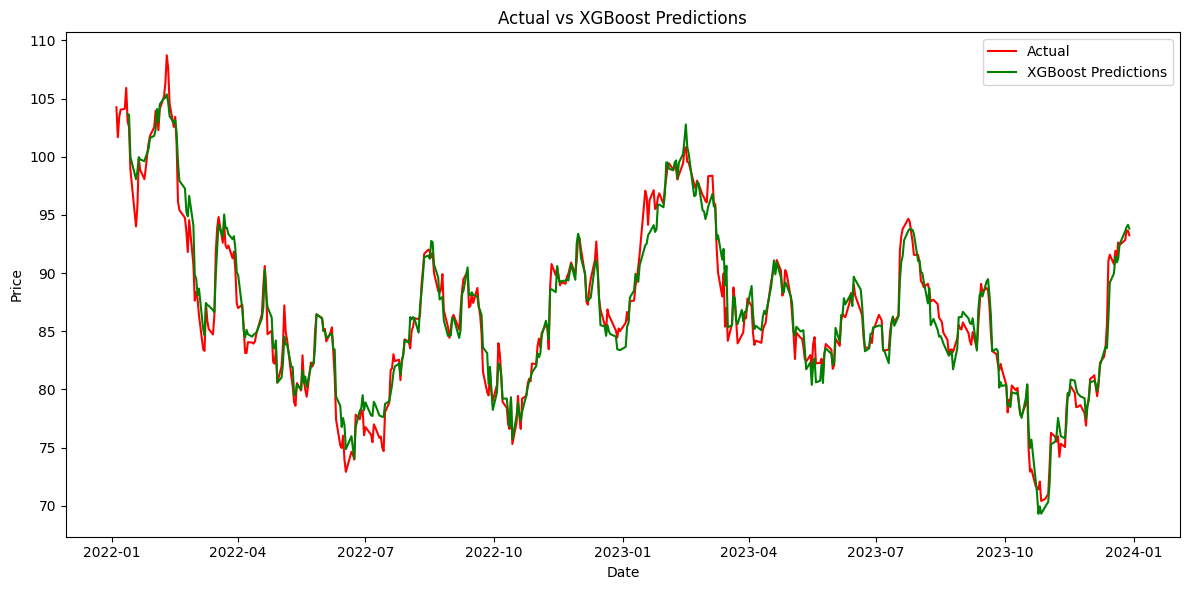

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(test.index.to_timestamp(), test.values, 'r', label='Actual')
plt.plot(y_test.index, xgb_predictions, 'g', label='XGBoost Predictions')

plt.title('Actual vs XGBoost Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

##Comparison Between XGBoost and Arima

---

The Graphs and Evaluation Metrics show that XGBoost is a better model in terms of Accuracy and Reliability compared to ARIMA

In [ ]:
arima_evaluation = evaluate_forecast(test, predictions)
print("ARIMA Model Evaluation:")
print(arima_evaluation)

ARIMA Model Evaluation:
{'MSE': 2.5893473683563615, 'RMSE': 1.6091449183825433, 'MAE': 1.211566408171572, 'MAPE': 1.401443892770737}


In [ ]:
xgb_evaluation = evaluate_forecast(y_test, xgb_predictions)
print("\nXgBoost Model Evaluation:")
print(xgb_evaluation)


XgBoost Model Evaluation:
{'MSE': 1.6625446158767394, 'RMSE': 1.2893969970015982, 'MAE': 0.9818901803329406, 'MAPE': 1.1403177684246728}


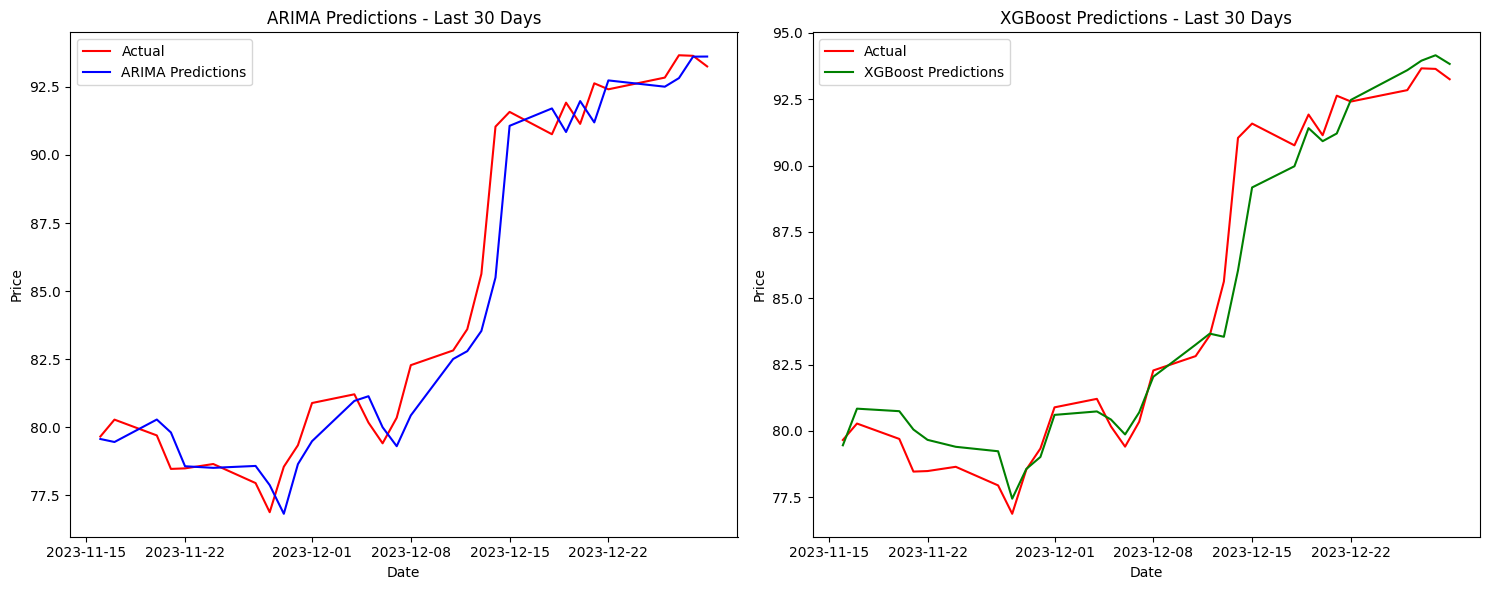

In [ ]:
last_30_days = test.index[-30:]
test_last_30 = test[-30:]
arima_last_30 = arima_predictions[-30:]
xgb_last_30 = xgb_predictions[-30:]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the actual and ARIMA predictions for the last 30 days
ax1.plot(test_last_30.index.to_timestamp(), test_last_30.values, 'r', label='Actual')
ax1.plot(test_last_30.index.to_timestamp(), arima_last_30, 'b', label='ARIMA Predictions')
ax1.set_title('ARIMA Predictions - Last 30 Days')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()

# Plot the actual and Gradient Boosting predictions for the last 30 days
ax2.plot(test_last_30.index.to_timestamp(), test_last_30.values, 'r', label='Actual')
ax2.plot(y_test.index[-30:], xgb_last_30, 'g', label='XGBoost Predictions')
ax2.set_title('XGBoost Predictions - Last 30 Days')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()

##Feature Importance Graph

<Figure size 1000x800 with 0 Axes>

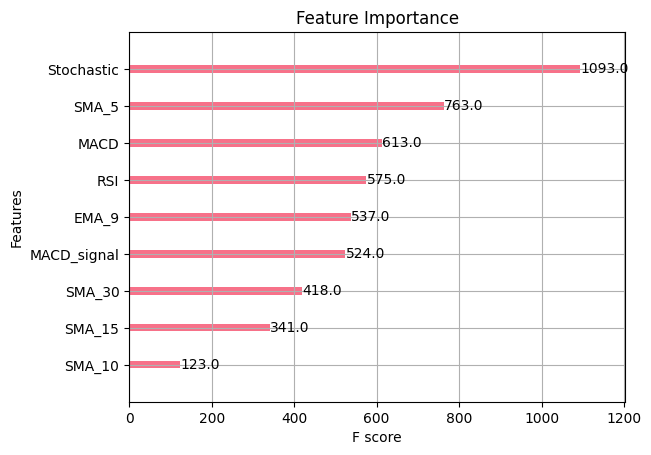

In [ ]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_model, importance_type='weight', title='Feature Importance')
plt.show()